In [1]:
# bloco com os imports
import numpy as np
from math import factorial as fac
from scipy.special import kv as kv
# import pandas as pd
import matplotlib.pyplot as pp
%matplotlib inline

In [2]:
# funcao que calcula os vj 
def calcvj(n):
#     verificando se n e par
    if n%2==1:
#         forcando n a ser par, caso necessario
        n=n+1
#     inicializando vj com zeros
    vj=np.zeros([n,1])
#     entrando no loop de j
    for j in range(1,n+1):
#         determinando o maximo do somatorio
        kmax=round(min(j,n/2))
#     determinando o minimo do somatorio
        if j%2 == 0:
            kmin=round(j/2)
        else:
            kmin = round((j+1)/2)
#       entrando no loop em k
        for k in range(kmin, kmax+1):
            num=np.power(k,1+n/2)*fac(2*k)
            den=fac(n/2-k)*fac(k)*fac(k)*fac(j-k)*fac(2*k-j)
            vj[j-1]=vj[j-1]+num/den
#     final do loop em k

        vj[j-1]=vj[j-1]*np.power(-1,j+n/2)
#     final do loop em j


#     retornando o vetor de vjs calculados
    return vj

In [3]:
# # invertendo uma funcao usando stehfest
# def stehfest(t):
# #     definindo o N de stehfest
#     n=12
# #     chamando a funcao para calcular os coeficientes vj
#     vj=calcvj(n)
# #     inicializando o vetor de valores aproximados com zeros
#     fa=np.zeros_like(t)
# #     buscando o comprimento do vetor de tempo
#     lent=len(t)
# #     entrando no loop em i (tamanho do vetor de tempo)
#     for i in range(0,lent):
# #         entrando no loop em j para inverter a funcao
#         for j in range(1,n+1):
# #         calculando a "variavel de Laplace"
#             u=j*np.log(2)/t[i]
# #           invertendo a funcao 1/u
#             fa[i]=fa[i]+vj[j-1]*1/u
# #             fim do loop em j
# #         multiplicando o valor aproximado por ln(2)/t
#         fa[i] = fa[i]*np.log(2)/t[i]
# #         fim do loop em i
# #     retornando o valor aproximado da funcao
#     return fa

In [4]:
# usando stehfest para obter a pressao no campo real
def stehfest(t,k,h,q,mu,eta,rw):
#     definindo o N de stehfest
    n=12
#     definindo a constante multiplicativa
    cons = q*mu/k/h
#     chamando a funcao para calcular os coeficientes vj
    vj=calcvj(n)
#     inicializando o vetor de valores aproximados com zeros
    fa=np.zeros_like(t)
#     buscando o comprimento do vetor de tempo
    lent=len(t)
#     entrando no loop em i (tamanho do vetor de tempo)
    for i in range(0,lent):
#         entrando no loop em j para inverter a funcao
        for j in range(1,n+1):
#         calculando a "variavel de Laplace"
            u=j*np.log(2)/t[i]
            arg = rw*np.sqrt(u/eta)
#           invertendo a funcao 1/u
            fa[i]=fa[i]+vj[j-1]*kv(0,arg)/u/arg/kv(1,arg)
#             fim do loop em j
#         multiplicando o valor aproximado por cons*ln(2)/t
        fa[i] = fa[i]*cons*np.log(2)/t[i]
#         fim do loop em i
#     retornando o valor aproximado da funcao
    return fa

In [5]:
# funcao que calcula a pressao usando a aproximacao logaritmica da linha fonte
def approxlog(t, q, mu, k, h, phi, ct, rw, alphat):
    
    gamma = .57722
    
    p=np.zeros_like(t)
    
    for i in range(0,len(t)):
        p[i] = np.log(4*alphat*k*t[i]/np.exp(gamma)/phi/mu/ct/rw/rw)
        p[i] = p[i]*q*mu/2/k/h
        
    return p

In [6]:
# funcao que calcula a derivada em relacao ao log de x
def deriv1(x,y):
#     inicializando o vetor da derivada com zeros
    dy = np.zeros_like(y)
    
    for i in range(1,len(x)):
        dy[i]=(y[i]-y[i-1])/np.log(x[i]/x[i-1])
    
    dy[0] = dy[1]
    
    return dy

In [7]:
# funcao que retorna os limites dos eixos para plot
def limcart(v):
    limi = np.zeros([2,1])
    limi[0] = np.floor(min(v))
    limi[1] = np.ceil(max(v))
    
    return limi

In [8]:
# funcao que retorna os limites dos eixos para loglog
def limlog(v):
    limi = np.zeros([2,1])
    limi[0] = np.log10(min(v))
    limi[1] = np.log10(max(v))
    
    limi[0] = np.power(10,np.floor(limi[0]))
    limi[1] = np.power(10,np.ceil(limi[1]))
    
    return limi

In [9]:
# definindo o tempo inicial
t0=1e-4
# definindo a constante multiplicativa
dt=np.power(10,1/5)
# definindo o numero de pontos
n=5*6+1
# inicializando o vetor de tempo
t=np.zeros([n,1])
# definindo primeiro ponto no vetor de tempo
t[0]=t0
#  criando o vetor de tempo
for i in range(1,n):
    t[i]=t[i-1]*dt

In [10]:
# bloco que define os parametros de entrada

# definindo as constantes de ajuste de unidades
alphap=19.03
alphat=.0003484

# vazao no poco (em m³/d)
q = 500
# permeabilidade (em mD)
k = 1000
# altura (em m)
h = 30
# viscosidade (em cP)
mu = 5.1
# porosidade (adimensional)
phi = .05
# raio do poco (em m)
rw=.1
# compressibilidade total (em (kgf/cm²)^-1)
ct = 5e-5

In [11]:
# ajustando a vazao
q = q*alphap
# calculando a difusividade hidraulica
eta = alphat*k/phi/mu/ct

# calculando a pressao usando stehfest
p = stehfest(t, k,h,q,mu,eta,rw)
# derivando a pressao
dp = deriv1(t,p)

# calculando a pressao usando a aprox log
p2 = approxlog(t, q, mu, k, h, phi, ct, rw, alphat)
# derivando a pressao
dp2 = deriv1(t,p2)

In [12]:
# buscando os limites dos eixos
lint = limlog(t)
lint[1]=lint[1]/10
liny = [0, max(p)]
liny = limlog([min(dp), max(p)])

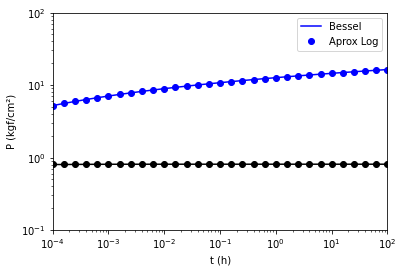

In [16]:
# tentando plotar
fig, ax = pp.subplots()
# titulo do eixo x
ax.set_xlabel('t (h)')
# titulo do eixo y
ax.set_ylabel('P (kgf/cm²)')
# limites do eixo x
ax.set_xlim(lint)
# limites do eixo y
ax.set_ylim(liny)
# plotando as curvas
ax.semilogx(t, p, 'b-', label = 'Bessel');
ax.semilogx(t, dp, 'k-');

ax.loglog(t, p2, 'bo', label = 'Aprox Log');
ax.semilogx(t, dp2, 'ko');


ax.legend(loc = 'best')

In [17]:
eta

27325.49019607843